In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')
%matplotlib inline
from joblib import dump, load
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error as MSE
from datetime import datetime
np.random.seed(42)
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AAPL.csv')

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.2.


In [4]:
df

Date        Open        High         Low       Close   Adj Close  \
0     2016-01-04   25.652500   26.342501   25.500000   26.337500   23.977478   
1     2016-01-05   26.437500   26.462500   25.602501   25.677500   23.376619   
2     2016-01-06   25.139999   25.592501   24.967501   25.174999   22.919146   
3     2016-01-07   24.670000   25.032499   24.107500   24.112499   21.951847   
4     2016-01-08   24.637501   24.777500   24.190001   24.240000   22.067928   
...          ...         ...         ...         ...         ...         ...   
1964  2023-10-23  170.910004  174.009995  169.929993  173.000000  172.772385   
1965  2023-10-24  173.050003  173.669998  171.449997  173.440002  173.211807   
1966  2023-10-25  171.880005  173.059998  170.649994  171.100006  170.874893   
1967  2023-10-26  170.369995  171.380005  165.669998  166.889999  166.670425   
1968  2023-10-27  166.910004  168.960007  166.830002  168.220001  167.998672   

         Volume Stock      Date.1  
0     270597600  AAPL  2016-01-04  
1     223164000  AAPL  2016-01-05  
2     273829600  AAPL  2016-01-06  
3     324377600  AAPL  2016-01-07  
4     283192000  AAPL  2016-01-08  
...         ...   ...         ...  
1964   55980100  AAPL  2023-10-23  
1965   43816600  AAPL  2023-10-24  
1966   57157000  AAPL  2023-10-25  
1967   70625300  AAPL  2023-10-26  
1968   58499100  AAPL  2023-10-27  

[1969 rows x 9 columns]

# Часть 1 | EDA

In [5]:
# основные статистики по числовым признакам
df.describe(include='all')

Date         Open         High          Low        Close  \
count         1969  1969.000000  1969.000000  1969.000000  1969.000000   
unique        1969          NaN          NaN          NaN          NaN   
top     2016-01-04          NaN          NaN          NaN          NaN   
freq             1          NaN          NaN          NaN          NaN   
mean           NaN    88.569326    89.564620    87.641367    88.645323   
std            NaN    54.484888    55.127220    53.878512    54.524054   
min            NaN    22.500000    22.917500    22.367500    22.584999   
25%            NaN    40.812500    41.187500    40.157501    40.762501   
50%            NaN    64.262497    65.087502    63.842499    64.610001   
75%            NaN   143.449997   145.550003   141.809998   143.429993   
max            NaN   196.240005   198.229996   195.279999   196.449997   

          Adj Close        Volume Stock      Date.1  
count   1969.000000  1.969000e+03  1969        1969  
unique          NaN           NaN     1        1969  
top             NaN           NaN  AAPL  2016-01-04  
freq            NaN           NaN  1969           1  
mean      86.876883  1.146123e+08   NaN         NaN  
std       54.879778  5.774958e+07   NaN         NaN  
min       20.798662  3.145820e+07   NaN         NaN  
25%       38.622047  7.666200e+07   NaN         NaN  
50%       63.094528  1.008271e+08   NaN         NaN  
75%      142.356827  1.352664e+08   NaN         NaN  
max      195.926956  5.334788e+08   NaN         NaN

# Из функции describe мы видим, что у нас топ, мода и уникальность во всех числовых признаках неизвестна


In [6]:
# проеврка на дубликаты 
len(df[df.duplicated()==True])

0

In [7]:
# просомотр пропусков 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1969 non-null   object 
 1   Open       1969 non-null   float64
 2   High       1969 non-null   float64
 3   Low        1969 non-null   float64
 4   Close      1969 non-null   float64
 5   Adj Close  1969 non-null   float64
 6   Volume     1969 non-null   int64  
 7   Stock      1969 non-null   object 
 8   Date.1     1969 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 138.6+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df['Stock'] = df['Stock'].astype(str)

In [10]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
Stock                object
Date.1               object
dtype: object

In [11]:
df

Date        Open        High         Low       Close   Adj Close  \
0    2016-01-04   25.652500   26.342501   25.500000   26.337500   23.977478   
1    2016-01-05   26.437500   26.462500   25.602501   25.677500   23.376619   
2    2016-01-06   25.139999   25.592501   24.967501   25.174999   22.919146   
3    2016-01-07   24.670000   25.032499   24.107500   24.112499   21.951847   
4    2016-01-08   24.637501   24.777500   24.190001   24.240000   22.067928   
...         ...         ...         ...         ...         ...         ...   
1964 2023-10-23  170.910004  174.009995  169.929993  173.000000  172.772385   
1965 2023-10-24  173.050003  173.669998  171.449997  173.440002  173.211807   
1966 2023-10-25  171.880005  173.059998  170.649994  171.100006  170.874893   
1967 2023-10-26  170.369995  171.380005  165.669998  166.889999  166.670425   
1968 2023-10-27  166.910004  168.960007  166.830002  168.220001  167.998672   

         Volume Stock      Date.1  
0     270597600  AAPL  2016-01-04  
1     223164000  AAPL  2016-01-05  
2     273829600  AAPL  2016-01-06  
3     324377600  AAPL  2016-01-07  
4     283192000  AAPL  2016-01-08  
...         ...   ...         ...  
1964   55980100  AAPL  2023-10-23  
1965   43816600  AAPL  2023-10-24  
1966   57157000  AAPL  2023-10-25  
1967   70625300  AAPL  2023-10-26  
1968   58499100  AAPL  2023-10-27  

[1969 rows x 9 columns]

# Доп признаки 


In [12]:
def prepare_df(df):
    df = df.drop('Stock', axis = 1)
    df['Date.1'] = pd.to_datetime(df['Date.1'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date.1', inplace=True)
    df = df.drop(columns = 'Date', axis = 1)
    
    return df
    

In [71]:
def split_df(df, type_df = 'new'):
    df['future_price'] = df['Close'].shift(-1) / df['Close']

    X_train, X_temp, y_train, y_temp = train_test_split(df.drop('future_price', axis=1), df.future_price, test_size=0.3, shuffle=False, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False, random_state=42)
    
    
    return X_train, X_val,X_test, y_train, y_val, y_test 
     

In [72]:
df_prepared = prepare_df(df)

In [73]:
X_train, X_val,X_test, y_train, y_val, y_test = split_df(df_prepared, type_df='pred')

In [74]:
X_train.shape, X_val.shape,X_test.shape

((1378, 6), (413, 6), (178, 6))

In [75]:
# функции
def create_features(_df):

        
# создание новых признаков
# среднее занчения за 3 5 7 14 30 90 дней
    _df['rolling_3D_Open_mean'] = _df['Open'].rolling(window=3).mean()
    _df['rolling_5D_Open_mean'] = _df['Open'].rolling(window=5).mean()
    _df['rolling_week_Open_mean'] = _df['Open'].rolling(window=7).mean()
    _df['rolling_2weeks_Open_mean'] = _df['Open'].rolling(window=14).mean()
    _df['rolling_mounth_Open_mean'] = _df['Open'].rolling(window=30).mean()
    _df['rolling_quartal_Open_mean'] = _df['Open'].rolling(window=90).mean()

    _df['rolling_3D_Close_mean'] = _df['Close'].rolling(window=3).mean()
    _df['rolling_5D_Close_mean'] = _df['Close'].rolling(window=5).mean()
    _df['rolling_week_Close_mean'] = _df['Close'].rolling(window=7).mean()
    _df['rolling_2weeks_Close_mean'] = _df['Close'].rolling(window=14).mean()
    _df['rolling_mounth_Close_mean'] = _df['Close'].rolling(window=30).mean()
    _df['rolling_quartal_Close_mean'] = _df['Close'].rolling(window=90).mean()

    _df['rolling_3D_High_mean'] = _df['High'].rolling(window=3).mean()
    _df['rolling_5D_High_mean'] = _df['High'].rolling(window=5).mean()
    _df['rolling_week_High_mean'] = _df['High'].rolling(window=7).mean()
    _df['rolling_2weeks_High_mean'] = _df['High'].rolling(window=14).mean()
    _df['rolling_mounth_High_mean'] = _df['High'].rolling(window=30).mean()
    _df['rolling_quartal_High_mean'] = _df['High'].rolling(window=90).mean()

    _df['rolling_3D_Low_mean'] = _df['Low'].rolling(window=3).mean()
    _df['rolling_5D_Low_mean'] = _df['Low'].rolling(window=5).mean()
    _df['rolling_week_Low_mean'] = _df['Low'].rolling(window=7).mean()
    _df['rolling_2weeks_Low_mean'] = _df['Low'].rolling(window=14).mean()
    _df['rolling_mounth_Low_mean'] = _df['Low'].rolling(window=30).mean()
    _df['rolling_quartal_Low_mean'] = _df['Low'].rolling(window=90).mean()
#     дисперсия по окнам за 3 5 7 14 30 90 дней
    _df['disp_3D_Open'] = _df['Open'].rolling(window=3).var()
    _df['disp_5D_Open'] = _df['Open'].rolling(window=5).var()
    _df['disp_week_Open'] = _df['Open'].rolling(window=7).var()
    _df['disp_2weeks_Open'] = _df['Open'].rolling(window=14).var()
    _df['disp_mounth_Open'] = _df['Open'].rolling(window=30).var()
    _df['disp_quartal_Open'] = _df['Open'].rolling(window=90).var()

    _df['disp_3D_Close'] = _df['Close'].rolling(window=3).var()
    _df['disp_5D_Close'] = _df['Close'].rolling(window=5).var()
    _df['disp_week_Close'] = _df['Close'].rolling(window=7).var()
    _df['disp_2weeks_Close'] = _df['Close'].rolling(window=14).var()
    _df['disp_mounth_Close'] = _df['Close'].rolling(window=30).var()
    _df['disp_quartal_Close'] = _df['Close'].rolling(window=90).var()

    _df['disp_3D_High'] = _df['High'].rolling(window=3).var()
    _df['disp_5D_High'] = _df['High'].rolling(window=5).var()
    _df['disp_week_High'] = _df['High'].rolling(window=7).var()
    _df['disp_2weeks_High'] = _df['High'].rolling(window=14).var()
    _df['disp_mounth_High'] = _df['High'].rolling(window=30).var()
    _df['disp_quartal_High'] = _df['High'].rolling(window=90).var()

    _df['disp_3D_Low'] = _df['Low'].rolling(window=3).var()
    _df['disp_5D_Low'] = _df['Low'].rolling(window=5).var()
    _df['disp_week_Low'] = _df['Low'].rolling(window=7).var()
    _df['disp_2weeks_Low'] = _df['Low'].rolling(window=14).var()
    _df['disp_mounth_Low'] = _df['Low'].rolling(window=30).var()
    _df['disp_quartal_Low'] = _df['Low'].rolling(window=90).var()
    # относительное изменение за день
    _df['relative_change_Open'] = _df['Open'] / _df['Open'].shift(1) 
    _df['relative_change_Close'] = _df['Close'] / _df['Close'].shift(1) 
    _df['relative_change_High'] =  _df['High'] /  _df['High'].shift(1)
    _df['relative_change_Low'] = _df['Low'] / _df['Low'].shift(1)
    #   вычисление логарифмической доходности
    _df['Log_Returns'] = np.log(_df['Close'] / _df['Open'])
    #   Стандартное отклонение 
    _df['Volatility_3D'] = _df['Log_Returns'].rolling(window=3).std()
    _df['Volatility_5D'] = _df['Log_Returns'].rolling(window=5).std()
    _df['Volatility_week'] = _df['Log_Returns'].rolling(window=7).std()
    _df['Volatility_2week'] = _df['Log_Returns'].rolling(window=14).std()
    _df['Volatility_mounth'] = _df['Log_Returns'].rolling(window=30).std()
    _df['Volatility_quartal'] = _df['Log_Returns'].rolling(window=90).std()
    #   изменение цены акции
    _df['Price Change'] = _df['Close'].diff()
    # период RSI
    n = 14
    # положительное и отрицательное изменение цены
    _df['Gain'] = _df['Price Change'].apply(lambda x: x if x > 0 else 0)
    _df['Loss'] = _df['Price Change'].apply(lambda x: -x if x < 0 else 0)
    # среднее значение изменения цены для заданного периода
    _df['Avg Gain'] = _df['Gain'].rolling(window=n).mean()
    _df['Avg Loss'] = _df['Loss'].rolling(window=n).mean()
    # отношение среднего прироста к среднему падению 
    relative_strength = _df['Avg Gain'] / _df['Avg Loss']
    # RSI
    _df['RSI'] = 100 - (100 / (1 + relative_strength))
    #    ежедневное изменение цены в %
    _df['% daily price change'] = _df['Close'].pct_change() * 100
#     процентное измнеение цены между завтра к сегодня
#     _df['future_price'] = _df['Close'].shift(-1) / _df['Close']

#     заполенение пропусков
#     _df = _df.dropna()

    return _df


In [76]:
X_train = create_features(X_train)
X_val = create_features(X_val)
X_test = create_features(X_test)

In [77]:
X_train = X_train.dropna()
X_val = X_val.dropna()
X_test = X_test.dropna()

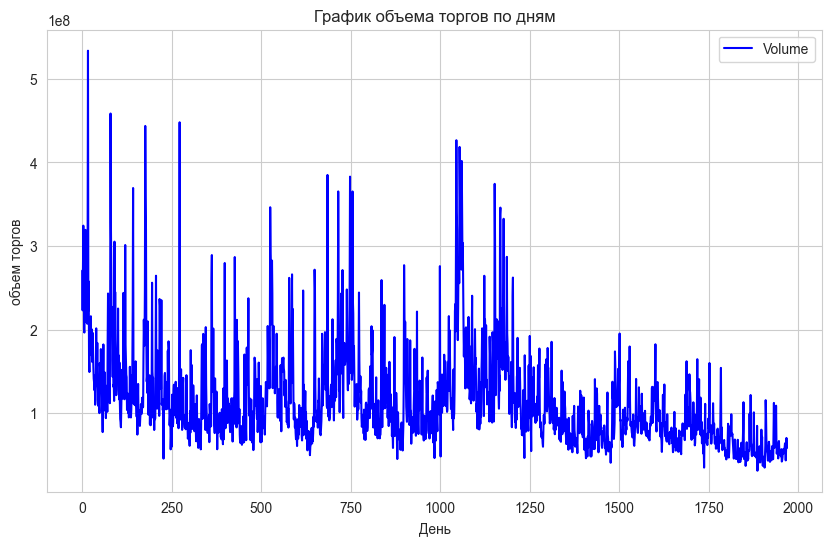

<Figure size 640x480 with 0 Axes>

In [19]:
# 1) график объема торгов по нему смогу узнать, какой интерес и когда появляется и людей
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Volume'], color='b', label='Volume')
plt.xlabel('День')
plt.ylabel('объем торгов')
plt.title('График объема торгов по дням')
plt.legend()
plt.show()
plt.savefig('stock_volume.png', format='png')

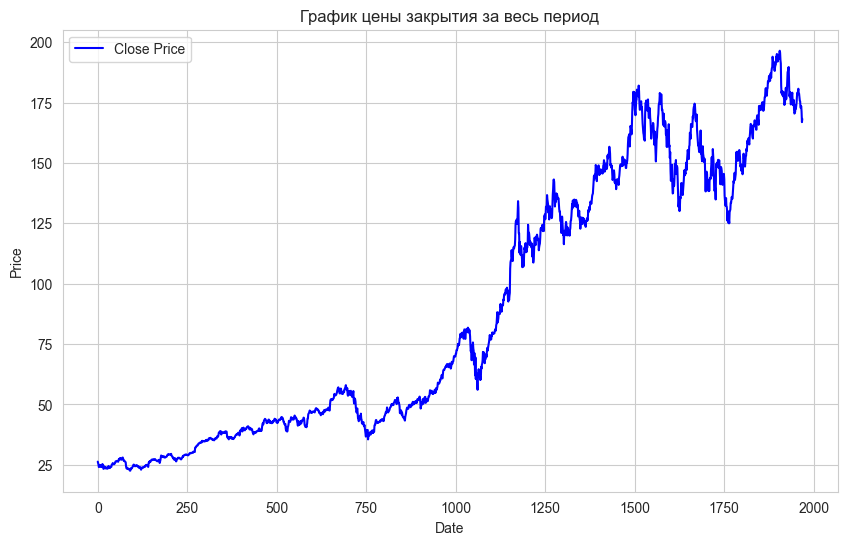

<Figure size 640x480 with 0 Axes>

In [20]:
# 2) График цены акции во времени
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], color='b', label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('График цены закрытия за весь период')
plt.legend()
plt.show()
plt.savefig('stock_prices.png', format='png')

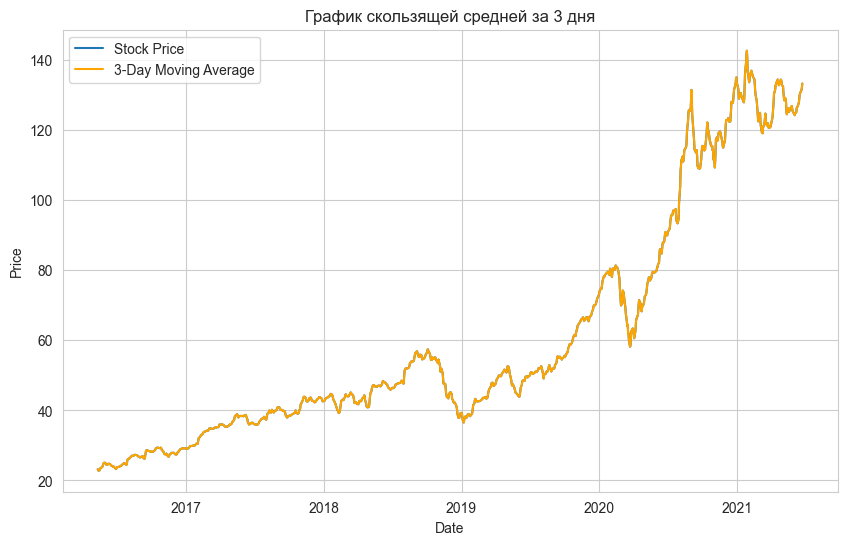

In [21]:
# 3) График скользящей средней
plt.figure(figsize=(10, 6))
plt.plot(X_train.index, X_train['rolling_3D_Close_mean'], label='Stock Price')
plt.plot(X_train['rolling_3D_Close_mean'].index, X_train['rolling_3D_Close_mean'], label='3-Day Moving Average', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('График скользящей средней за 3 дня')
plt.legend()
plt.show()

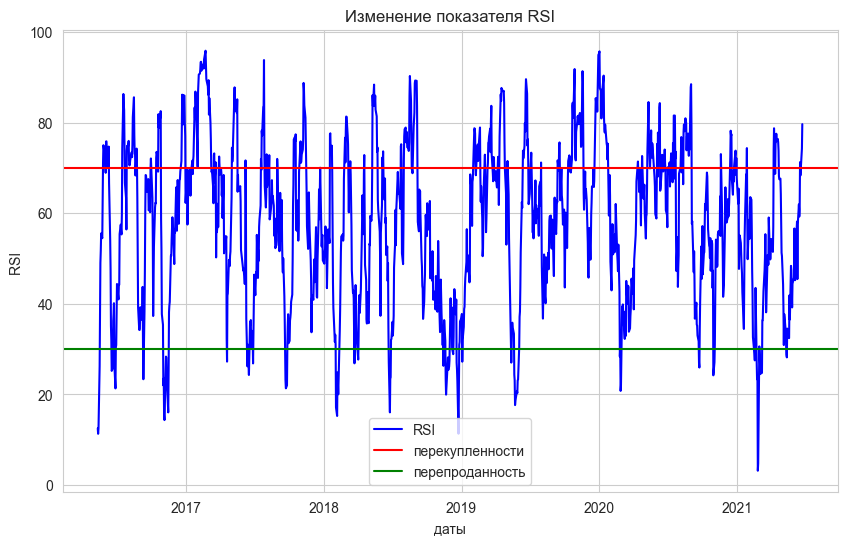

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(X_train.index, X_train['RSI'], label='RSI', color='b')
plt.axhline(y=70, color='r', linestyle='-', label='перекупленности')
plt.axhline(y=30, color='g', linestyle='-', label='перепроданность')
plt.xlabel('даты')
plt.ylabel('RSI ')
plt.title('Изменение показателя RSI')
plt.legend()
plt.show()

In [24]:
# import plotly.express as px

# fig = px.line(X_train, x=X_train.index, y="% daily price change")
# fig.update_layout(title="Изменение в % цены акции", width=800, height=600)
# fig.show()

In [79]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Стандартизация
scale = StandardScaler()
scale.fit_transform(X_train)
dump(scale, 'scale.pkl')

def standard(x):
    scaler = load('scale.pkl')
    X_ohe_scale = scaler.transform(x)
    X_ohe_scale = pd.DataFrame(X_ohe_scale, columns = x.columns)
    
    return X_ohe_scale
X_train_scal = standard(X_train)
X_val_scal = standard(X_val)
X_test_scal = standard(X_test)

In [80]:
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]
y_test = y_test.loc[X_test.index]

In [101]:
y_train.min()- y_train.max()

-0.24845522251305396

In [81]:
model_dl = nn.Sequential(nn.Linear(X_train_scal.shape[1], 64), nn.ReLU(),nn.Dropout(0.1), nn.Linear(64, 1))
train_loader = DataLoader(list(zip(torch.tensor(X_train_scal.values, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))), batch_size=32, shuffle=True)

val_loader = DataLoader(list(zip(torch.tensor(X_val_scal.values, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))), batch_size=32)
optimizer = optim.Adam(model_dl.parameters())
loss_func = nn.L1Loss()

In [82]:

for epoch in tqdm(range(100)):
    train_loss = 0
    val_loss = 0
    model_dl.train()
    for x,y in train_loader:
        optimizer.zero_grad()
        pred = model_dl(x)
        loss = loss_func(pred,y)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    model_dl.eval()
    for x,y in val_loader:
        with torch.no_grad():
            pred = model_dl(x)
        loss = loss_func(pred,y)
        val_loss += loss.item()
    if epoch % 10 == 0:
        print(train_loss/len(train_loader), val_loss/len(val_loader))
    

  6%|████▉                                                                             | 6/100 [00:00<00:03, 25.71it/s]

0.424942309173142 0.4097845418886705


 15%|████████████▏                                                                    | 15/100 [00:00<00:03, 26.43it/s]

0.0802622969012435 0.14911973002282056


 24%|███████████████████▍                                                             | 24/100 [00:00<00:02, 26.23it/s]

0.057005463213455385 0.11097224124453285


 33%|██████████████████████████▋                                                      | 33/100 [00:01<00:02, 25.16it/s]

0.04450493451298737 0.06785451824014838


 45%|████████████████████████████████████▍                                            | 45/100 [00:01<00:02, 24.51it/s]

0.03729346212817401 0.057487906380133194


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:02<00:01, 25.35it/s]

0.03185599142821824 0.03908196481114084


 63%|███████████████████████████████████████████████████                              | 63/100 [00:02<00:01, 25.46it/s]

0.025694283406908918 0.04304895448413762


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:02<00:00, 25.93it/s]

0.022087634359372825 0.03320148705758832


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:03<00:00, 26.30it/s]

0.01902380072307296 0.031508493829857216


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:03<00:00, 26.21it/s]

0.01703135001404983 0.023342885584993797


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.75it/s]


In [85]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/179.2 kB ? eta -:--:--
   -- ------------------------------------- 10.2/179.2 kB ? eta -:--:--
   ------------- ------------------------- 61.4/179.2 kB 812.7 kB/s eta 0:00:01
   -------------------------------------- - 174.1/179.2 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 179.2/179.2 kB 1.5 MB/s eta 0:00:00


In [99]:
# from torcheval.metrics.functional import 
torch_X = torch.tensor(X_val_scal.values, dtype=torch.float32)
torch_y = torch.tensor(y_val.fillna(1).values.reshape(-1,1), dtype=torch.float32)
target = model_dl(torch_X)
# torch_y, target
torch.nn.functional.l1_loss(torch_y, target)

tensor(0.0200, grad_fn=<MeanBackward0>)

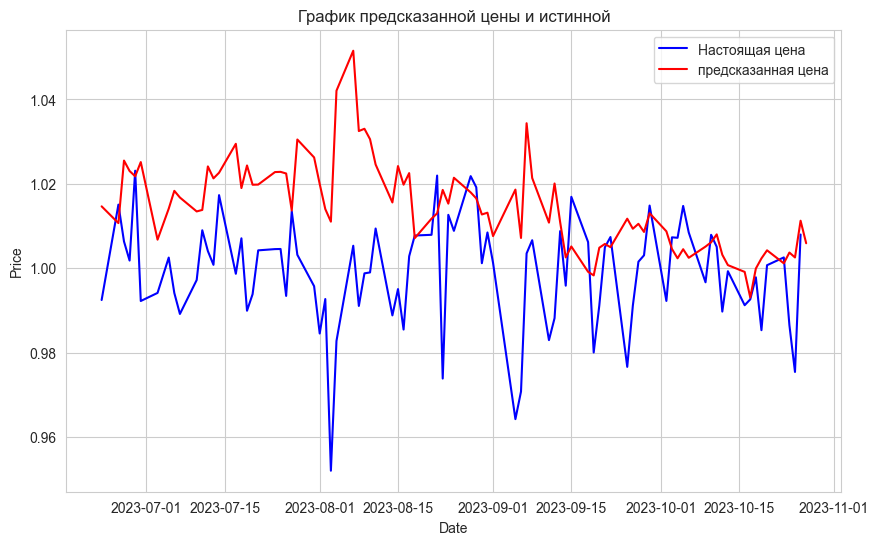

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label='Настоящая цена', color = 'b')
plt.plot(X_test.index, model_dl(torch.tensor(X_test_scal.values, dtype=torch.float32)).detach().numpy() , label='предсказанная цена', color = 'r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('График предсказанной цены и истинной')
plt.legend()
plt.show()

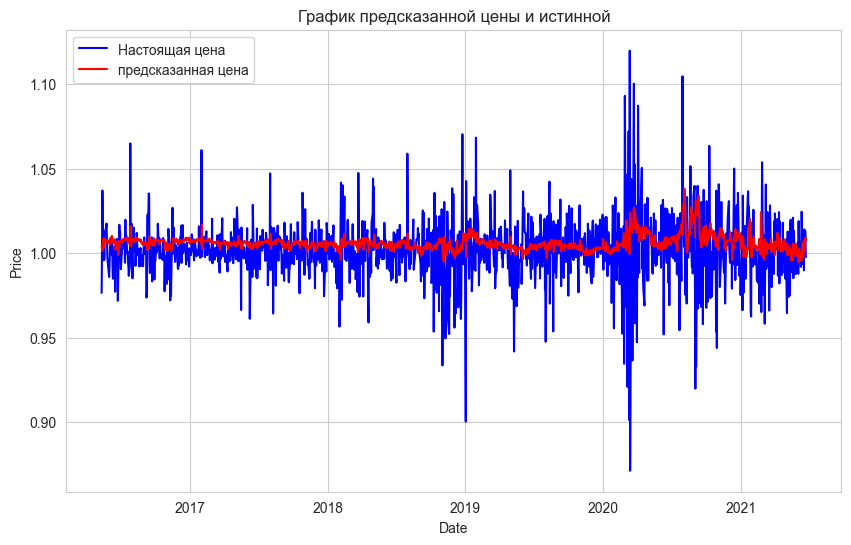

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(X_train.index, y_train, label='Настоящая цена', color = 'b')
plt.plot(X_train.index, model_dl(torch.tensor(X_train_scal.values, dtype=torch.float32)).detach().numpy() , label='предсказанная цена', color = 'r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('График предсказанной цены и истинной')
plt.legend()
plt.show()


In [32]:
model_ridge = Ridge()
model_lin = LinearRegression()
model_las = Lasso()

In [33]:
model_ridge.fit(X_train_scal, y_train)
model_lin.fit(X_train_scal, y_train)
model_las.fit(X_train_scal, y_train)



Lasso()

In [104]:
from sklearn.metrics import mean_absolute_error

In [105]:
pred_ridge = model_ridge.predict(X_val_scal)
pred_lin = model_lin.predict(X_val_scal)
pred_las = model_las.predict(X_val_scal)

In [108]:
mean_absolute_error_val_ridge = mean_absolute_error(y_val, pred_ridge)
mean_absolute_error_val_lin = mean_absolute_error(y_val, pred_lin)
mean_absolute_error_val_las = mean_absolute_error(y_val, pred_las)

# mse_train_ridge = MSE(y_val, pred_ridge) 
# mse_train_lin = MSE(y_val, pred_lin) 
# mse_train_las = MSE(y_val, pred_las) 

In [109]:
print(f'ridge mean_absolute_error:{mean_absolute_error_val_ridge}, lin mean_absolute_error:{mean_absolute_error_val_lin}, las mean_absolute_error: {mean_absolute_error_val_las}')

# print(f'MSE ridge:{mse_train_ridge}, MSE lin:{mse_train_lin}, MSE las:{mse_train_las}')

ridge mean_absolute_error:0.019897478206137194, lin mean_absolute_error:0.024596676243257853, las mean_absolute_error: 0.016497301562087095


In [110]:
# подбор гиперпараметров для Линейнойрегрессии
param_grid ={
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}
grid_search_lin = GridSearchCV(model_lin, param_grid, cv=58)
grid_search_lin.fit(X_train_scal,y_train)
print("Оптимальные значения гиперпараметров:", grid_search_lin.best_params_)

Оптимальные значения гиперпараметров: {'copy_X': True, 'fit_intercept': True}


In [111]:
parameters = {'alpha': [0.01, 0.1, 1, 10, 100, 1000, 5000, 10_000, 20_000, 50_000, 100_000, 500_000, 1_000_00]}
grid_search_ridge= GridSearchCV(model_ridge, parameters, cv = 58)
grid_search_las= GridSearchCV(model_las, parameters, cv = 58)

grid_search_ridge.fit(X_train_scal, y_train)
grid_search_las.fit(X_train_scal, y_train)

grid_val_ridge = grid_search_ridge.predict(X_val_scal)
grid_val_las = grid_search_las.predict(X_val_scal)


best_alpha_ridge = grid_search_ridge.best_params_['alpha']
best_alpha_las = grid_search_las.best_params_['alpha']

print(f'Оптимальный вариант для Ridge: {best_alpha_ridge}, las: {best_alpha_las}')

Оптимальный вариант для Ridge: 500000, las: 0.01


In [112]:
model_ridge_best = Ridge(alpha=500000) 
model_las_best = Lasso(alpha=0.01)

model_ridge_best.fit(X_train, y_train)
model_las_best.fit(X_train, y_train)

new_predict_ridge = model_ridge_best.predict(X_val_scal)
new_predict_las = model_las_best.predict(X_val_scal)


mean_absolute_error_new_ridge = mean_absolute_error(y_val, new_predict_ridge)
mean_absolute_error_new_las = mean_absolute_error(y_val, new_predict_las)

# mse_new_ridge = MSE(y_val, new_predict_ridge) 
# mse_new_las = MSE(y_val, new_predict_las) 

print(f'ridge mean_absolute_error:{mean_absolute_error_new_ridge},las mean_absolute_error: {mean_absolute_error_new_las}')

# print(f'MSE ridge:{mse_new_ridge}, MSE las:{mse_new_las}')

ridge mean_absolute_error:0.016460423538531055,las mean_absolute_error: 0.016454466203189574


In [113]:
df_pred = pd.DataFrame({'val_cost': X_val['Close'], 'predict': X_val['Close']*new_predict_ridge})
df_pred = df_pred.reindex(X_val.index)
df_pred

val_cost     predict
Date.1                            
2021-10-29  149.800003  149.758919
2021-11-01  148.960007  148.915841
2021-11-02  150.020004  149.973639
2021-11-03  151.490005  151.442980
2021-11-04  150.960007  150.917070
...                ...         ...
2023-02-07  154.649994  154.556211
2023-02-08  151.919998  151.840911
2023-02-09  150.869995  150.790415
2023-02-10  151.009995  150.931092
2023-02-13  153.850006  153.764800

[324 rows x 2 columns]

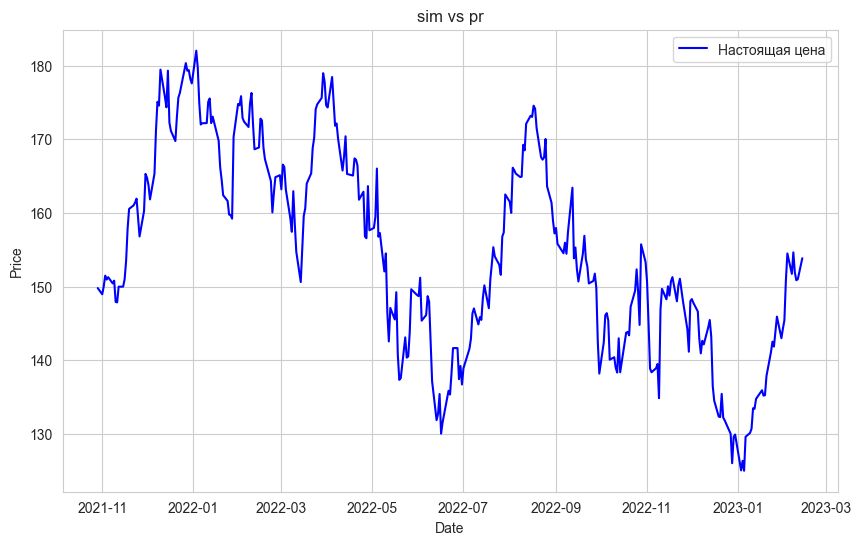

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(df_pred.index, df_pred.val_cost, label='Настоящая цена', color = 'b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('sim vs pr')
plt.legend()
plt.show()

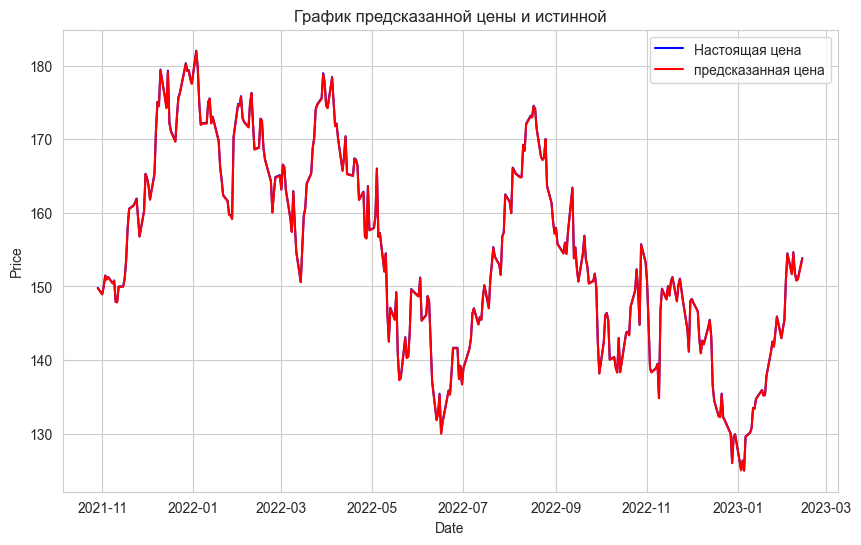

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(df_pred.index, df_pred.val_cost, label='Настоящая цена', color = 'b')
plt.plot(df_pred.index, df_pred.predict , label='предсказанная цена', color = 'r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('График предсказанной цены и истинной')
plt.legend()
plt.show()


In [43]:
# 2) График цены акции во времени
# plt.figure(figsize=(10, 6))
# plt.plot(df_train.index, df_train['Close'], color='b', label='Close Price')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('График цены закрытия за весь период')
# plt.legend()
# plt.show()


In [116]:
%%time
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
parametrs ={
    'n_estimators': [1, 2],
                    
    'alpha': [0.1,0.3],

    'max_depth': [1] 

}
xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(xgb_model, parameters, cv = 71, scoring = 'neg_mean_squared_error', verbose=1)


grid_search_fit = grid_search.fit(X_train, y_train)



print(grid_search_fit.best_params_)
print(grid_search_fit.best_score_)
print(grid_search_fit.best_estimator_)

Fitting 71 folds for each of 13 candidates, totalling 923 fits
{'alpha': 1}
-0.00036077205427566137
XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)
CPU times: total: 7min 45s
Wall time: 1min 18s


In [45]:
import time

In [46]:
from sklearn.metrics import r2_score

In [117]:
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'alpha': [0.1,0.3],
    'n_estimators': [50],
    'max_depth': [2,3,4,5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(param_grid=gbm_param_grid, estimator=gbm, 
                        scoring='neg_mean_squared_error', cv=71, verbose=1)

# Fit grid_mse to the data
grid_mse.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 71 folds for each of 16 candidates, totalling 1136 fits
Best parameters found:  {'alpha': 0.1, 'colsample_bytree': 0.3, 'max_depth': 2, 'n_estimators': 50}
Lowest RMSE found:  0.01925722088902278


In [124]:
%%time
from sklearn import tree
param_decision_tree ={
    'max_depth' : [2,3,4,5],
    'min_samples_leaf' : [None,1,2,3,4,5],
    'max_features' : [10,25,50,72],
    'random_state' : [42]
}
dtGSCV_dtree = tree.DecisionTreeRegressor()
grid_dtree = GridSearchCV(param_grid=param_decision_tree, estimator=dtGSCV_dtree, cv=7, verbose=1)

grid_dtree.fit(X_train_scal, y_train)
print(grid_dtree.best_params_, np.sqrt(np.abs(grid_dtree.best_score_)))

Fitting 7 folds for each of 96 candidates, totalling 672 fits
{'max_depth': 4, 'max_features': 25, 'min_samples_leaf': 3, 'random_state': 42} 0.09892952045217308
CPU times: total: 8.77 s
Wall time: 8.77 s


In [121]:
from sklearn import tree
model_tree= tree.DecisionTreeRegressor(random_state=42, max_depth=None, max_features=25, min_samples_leaf=3)
model_tree.fit(X_train_scal, y_train)
predict_tree = model_tree.predict(X_test) 

In [122]:
y_test = y_test.dropna() 

In [123]:
print(mean_absolute_error(y_test, predict_tree[:88]))

0.05492336583955089


In [125]:
%%time
from sklearn.ensemble import RandomForestRegressor
param_rand_for ={
    'n_estimators' : [1,2,3,4,5],
    'max_depth' : [1,2,3,4],
    'min_samples_leaf' : [1,2,3,4],
    'max_features' : [10,25,50],
    'random_state' : [42]
}
rfGSCV = RandomForestRegressor()
grid_random_forest= GridSearchCV(param_grid=param_rand_for, estimator=rfGSCV, cv=7, verbose=1)
grid_random_forest.fit(X_train_scal, y_train)
print(grid_random_forest.best_params_, np.sqrt(np.abs(grid_random_forest.best_score_)))

Fitting 7 folds for each of 240 candidates, totalling 1680 fits
{'max_depth': 1, 'max_features': 25, 'min_samples_leaf': 3, 'n_estimators': 3, 'random_state': 42} 0.07506187685430835
CPU times: total: 31.1 s
Wall time: 31.2 s


In [126]:
model_rnfr= RandomForestRegressor(max_depth=2, max_features=10, min_samples_leaf=1, n_estimators=4, random_state=42)
model_rnfr.fit(X_train_scal, y_train)
predict_rand_fr = model_rnfr.predict(X_test)
print(mean_absolute_error(y_test, predict_rand_fr[:88]))

0.02094877377674629


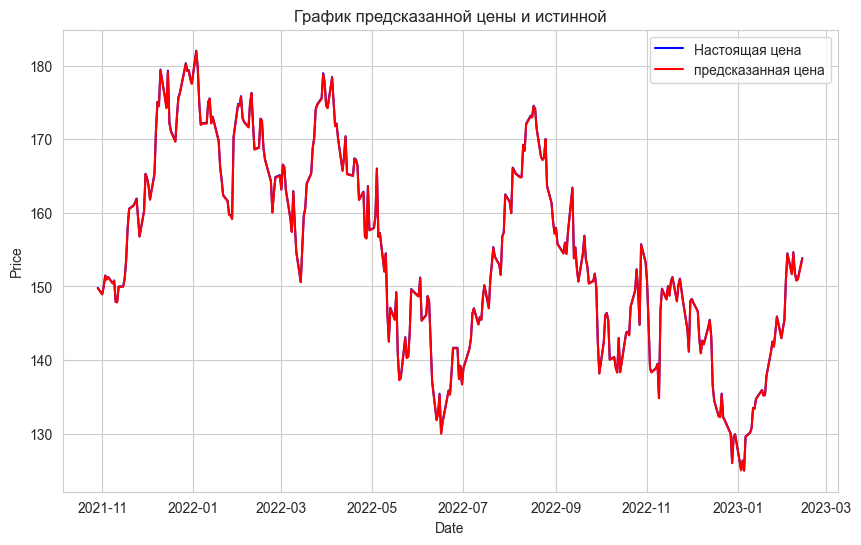

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(df_pred_rf.index, df_pred_rf.val_cost, label='Настоящая цена', color = 'b')
plt.plot(df_pred_rf.index, df_pred_rf.predict , label='предсказанная цена', color = 'r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('График предсказанной цены и истинной')
plt.legend()
plt.show()

In [128]:
val_rand_fr = model_rnfr.predict(X_val)

In [129]:
df_pred_rf = pd.DataFrame({'val_cost': X_val['Close'], 'predict': X_val['Close']*val_rand_fr})
df_pred_rf = df_pred.reindex(X_val.index)

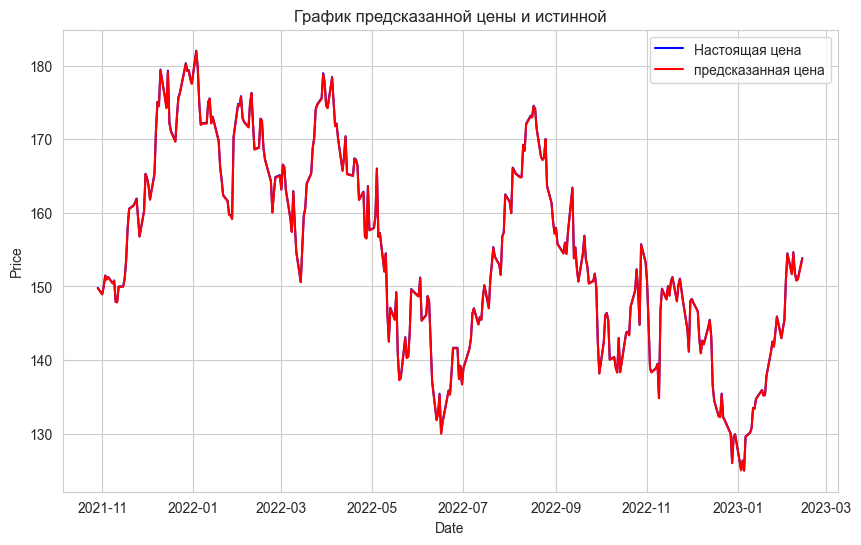

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(df_pred_rf.index, df_pred_rf.val_cost, label='Настоящая цена', color = 'b')
plt.plot(df_pred_rf.index, df_pred_rf.predict , label='предсказанная цена', color = 'r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('График предсказанной цены и истинной')
plt.legend()
plt.show()

In [131]:
df_pred = pd.DataFrame({'val_cost': X_val['Close'], 'predict': X_val['Close']*new_predict_ridge})
df_pred = df_pred.reindex(X_val.index)

In [132]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train_scal, y_train)
predict_xgb = model_xgb.predict(X_test)
print(mean_absolute_error(y_test, predict_xgb[:88]))

0.051666709173425446


In [133]:
# decisionTreee
from sklearn import tree
model_tree= tree.DecisionTreeRegressor(random_state=42)
model_tree.fit(X_train_scal, y_train)
predict_tree = model_tree.predict(X_test) 
print(mean_absolute_error(y_test, predict_tree[:88]))

0.07895947350052664


In [134]:
# Randomforest
from sklearn.ensemble import RandomForestRegressor
model_rand_for = RandomForestRegressor(random_state=42, max_depth=3)
model_rand_for.fit(X_train_scal, y_train)
predict_rand_for = model_rand_for.predict(X_test)
print(mean_absolute_error(y_test, predict_rand_for[:88]))

0.019920521858338588
